In [1]:
import itertools
import pathlib

import yaml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.transforms

import lab.metrics
import lab.analytics

sns.set_style("white")
plt.rcParams.update({
    'font.size': 8,
    'axes.titlesize': 8,
    'legend.fontsize': 8,
})
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

WITH_GRID = False

In [4]:
DEFENCE = "front"
SETTING = "mconn"
INPUTS = [
    f"../../results/ml-eval-{SETTING}/defence~{path}/classifier~{classifier}/predictions.csv"
    for classifier in ["kfp", "varcnn", "varcnn-time", "varcnn-sizes"]
    for path in [DEFENCE] + ([f"simulated-{DEFENCE}"] if SETTING == "conn" else [])
]
OUTPUT_FILE = pathlib.Path("/tmp/plot.png")
WITH_LEGEND = True
WITH_SIMULATED = (SETTING == "conn")

if "snakemake" in globals():
    INPUTS = list(snakemake.input)
    OUTPUT_FILE = pathlib.Path(snakemake.output[0])
    WITH_LEGEND = snakemake.params.get("with_legend", False)
    WITH_SIMULATED = snakemake.params.get("with_simulated", True)

In [12]:
def _load_data(inputs):
    data = (pd.concat([
                pd.read_csv(fname, header=0) for fname in inputs
            ], keys=inputs, names=["path"])
            .fillna(0)
            .rename(columns=lambda c: int(c) if c != "y_true" else c)
            .astype({"y_true": int})
            .drop(columns=[-1])
            .assign(
                is_simulated=lambda x: x.index.get_level_values("path").str.contains("simulated"),
                defence=lambda x: x.index.get_level_values("path").map(
                    lambda s: next(defence for defence in ["front", "tamaraw", "undefended"] if defence in s)
                ),
                classifier=lambda x: x.index.get_level_values("path").map(
                    lambda s: next(classifier for classifier in ["kfp", "dfnet", "varcnn-time", "varcnn-sizes", "varcnn"] if classifier in s)
                ))
            .set_index(["defence", "classifier", "is_simulated"])
            .rename(index={"front": "FRONT", "tamaraw": "Tamaraw", "undefended": "Undefended",
                           "kfp": "$k$-FP", "dfnet": "DF", "varcnn": "Var-CNN"})
           )
    return data

data = _load_data(INPUTS)
data

y_true             0             1  \
defence classifier   is_simulated                                       
FRONT   $k$-FP       False             57  0.000000e+00  0.000000e+00   
                     False             29  0.000000e+00  0.000000e+00   
                     False             81  0.000000e+00  0.000000e+00   
                     False             64  0.000000e+00  0.000000e+00   
                     False             95  0.000000e+00  0.000000e+00   
...                                   ...           ...           ...   
        varcnn-sizes False             32  2.056234e-15  2.308564e-07   
                     False             65  5.523403e-13  1.071370e-07   
                     False             40  8.335791e-18  2.400245e-11   
                     False             26  7.993021e-15  1.681661e-12   
                     False             56  4.302975e-20  1.706838e-21   

                                              2             3             4  \
defence classifier   is_simulated                                             
FRONT   $k$-FP       False         0.000000e+00  0.000000e+00  0.000000e+00   
                     False         0.000000e+00  5.000000e-01  0.000000e+00   
                     False         0.000000e+00  5.000000e-01  0.000000e+00   
                     False         0.000000e+00  0.000000e+00  0.000000e+00   
                     False         0.000000e+00  0.000000e+00  0.000000e+00   
...                                         ...           ...           ...   
        varcnn-sizes False         1.499654e-20  2.986746e-11  1.005830e-12   
                     False         9.224604e-17  1.044992e-11  8.998888e-11   
                     False         6.052812e-21  1.951813e-04  8.858181e-19   
                     False         5.835082e-12  6.059058e-07  1.738019e-13   
                     False         1.203972e-18  4.185733e-25  1.157417e-30   

                                              5             6             7  \
defence classifier   is_simulated                                             
FRONT   $k$-FP       False         0.000000e+00  0.000000e+00  0.000000e+00   
                     False         0.000000e+00  0.000000e+00  0.000000e+00   
                     False         0.000000e+00  0.000000e+00  0.000000e+00   
                     False         0.000000e+00  0.000000e+00  0.000000e+00   
                     False         0.000000e+00  0.000000e+00  0.000000e+00   
...                                         ...           ...           ...   
        varcnn-sizes False         3.422954e-16  6.294985e-12  1.137840e-17   
                     False         6.842186e-17  5.010913e-04  2.141630e-15   
                     False         1.258349e-17  1.068038e-11  1.483117e-16   
                     False         1.414789e-12  2.350273e-08  5.765592e-09   
                     False         3.048740e-21  2.816748e-24  1.047249e-21   

                                              8  ...            90  \
defence classifier   is_simulated                ...                 
FRONT   $k$-FP       False         0.000000e+00  ...  0.000000e+00   
                     False         0.000000e+00  ...  0.000000e+00   
                     False         0.000000e+00  ...  0.000000e+00   
                     False         0.000000e+00  ...  0.000000e+00   
                     False         0.000000e+00  ...  0.000000e+00   
...                                         ...  ...           ...   
        varcnn-sizes False         6.537420e-14  ...  6.132814e-22   
                     False         1.542773e-08  ...  2.355890e-17   
                     False         1.652951e-14  ...  7.746734e-24   
                     False         1.697494e-15  ...  3.087359e-05   
                     False         4.056752e-24  ...  1.357369e-19   

                                             91            92            93  \
defence classifier   is_simulated      

In [14]:
def precision_recall_curve(df):
    result = lab.analytics.rprecision_recall_curve(df["y_true"], df.drop("y_true", axis=1), ratio=20)
    return pd.DataFrame({
        "precision": result.precision,
        "recall": result.recall,
    })

# def plot_pr_curve(data):
#     data = (data
#             .transform(lambda x: x*100)
#             .rename({"dfnet": "DF", "varcnn": "Var-CNN", "p1fp": "$p$-FP(C)", "kfp": "$k$-FP"}, axis=0)
#             .rename({"precision": "$\pi_{20}$ (\%)", "recall": "Recall (\%)"}, axis=1)
#             .reset_index())
#     display(data)
# 
#     with plt.style.context([]):#"./mpl-style/pr-curve.mplstyle", "./mpl-style/pets.mplstyle", {"text.usetex": True}]):
#         grid = sns.relplot(
#             data=data, x="Recall (\%)", y="$\pi_{20}$ (\%)", hue="factor",
#             style="factor", col="classifier", kind="line", 
#             facet_kws=dict(legend_out=True, despine=False,
#                            gridspec_kws=dict(wspace=.1)),
#             palette="binary", legend=True
#         )
#         grid.set_titles(col_template="{col_name}")
#         
#         for i, ax in enumerate(np.ravel(grid.axes)):
#             # if i == 0:
#             #     ax.legend(labels=["Unmon.", "Control", "Both"])
#             ax.set_xticks([0, 50, 100])
#             ax.set_yticks([0, 50, 100])
#             ax.xaxis.get_major_formatter()._usetex = False
#             ax.yaxis.get_major_formatter()._usetex = False
#         
#     return grid

In [15]:
pr_scores = (data.groupby(["defence", "classifier", "is_simulated"])
             .apply(lambda x: precision_recall_curve(x)))
             # .set_index("thresholds", append=True))
pr_scores

precision  recall
defence classifier  is_simulated                       
FRONT   $k$-FP      False        0     0.033857  0.7110
                                 1     0.060785  0.7100
                                 2     0.083927  0.6245
                                 3     1.000000  0.0000
        Var-CNN     False        0     0.044643  0.9375
...                                         ...     ...
        varcnn-time False        542   0.584997  0.4250
                                 543   0.659628  0.3905
                                 544   0.767013  0.3325
                                 545   1.000000  0.0000
                                 546   1.000000  0.0000

[1477 rows x 2 columns]

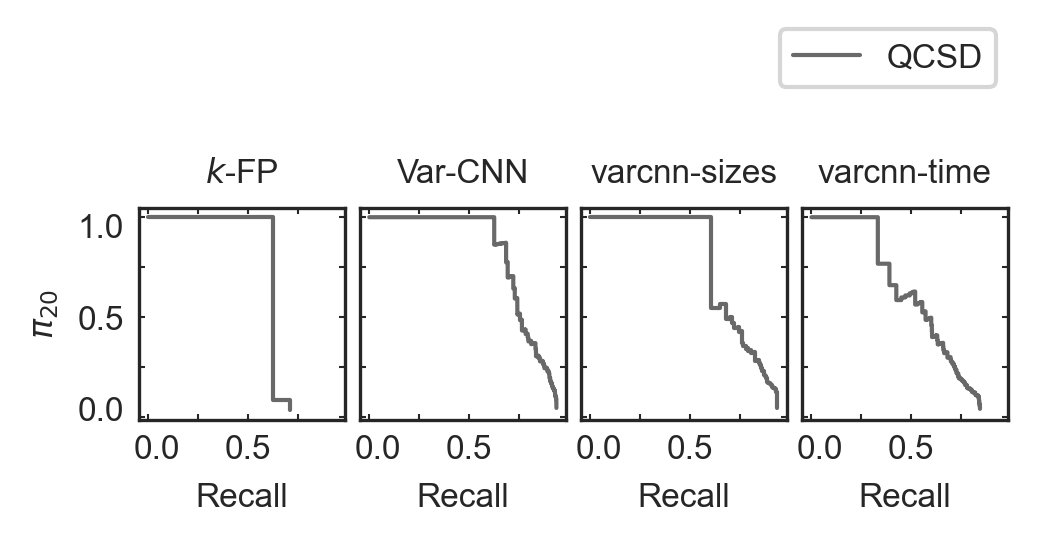

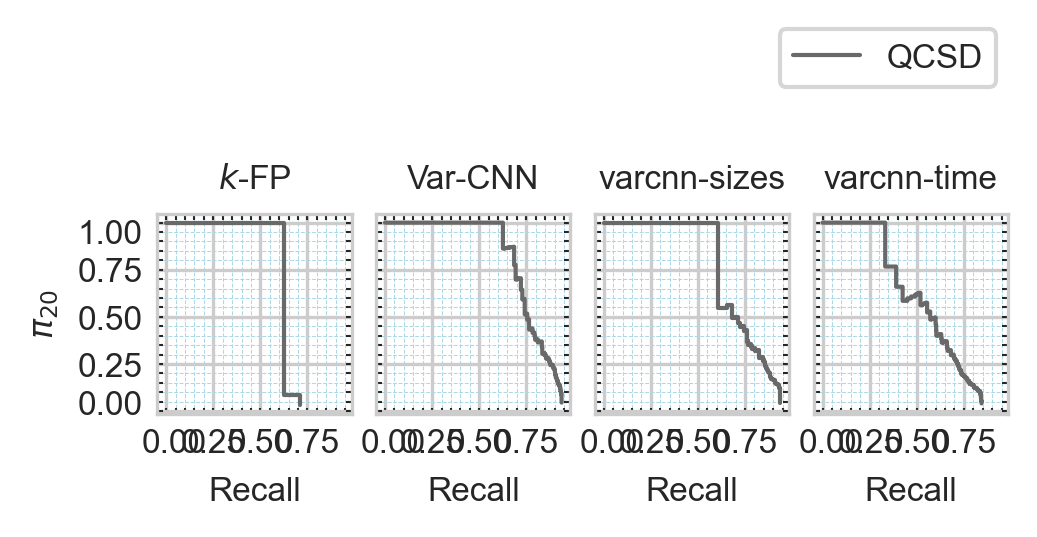

In [20]:
linestyles = {
    "Undef.": "-.",
    "Simulated": ":",
    "QCSD": "-"
}
    
    

def plot_pr_curves(plot_data, with_grid=False):
    if not WITH_SIMULATED:
        plot_data = plot_data.xs(False, level="is_simulated", drop_level=False)
    
    n_plots = len(plot_data.index.unique("classifier"))
    fig, axes_arr = plt.subplots(1, n_plots, figsize=(3.5, 2), sharex=True, sharey=True, dpi=300)
    for classifier, axes in  zip(plot_data.index.unique("classifier"), axes_arr.ravel()):
        for defence, color in zip(plot_data.index.unique("defence"), ["#1f77b4", "#ff7f0e"]):
            for is_simulated in [False, True]:
                if (
                    defence == "Undefended" and is_simulated
                    or is_simulated and not WITH_SIMULATED
                ):
                    continue
                
                label = "QCSD" if not is_simulated else "Simulated"
                # label = defence if defence == "Undefended" else f"{defence} ({label})"
                label = defence if defence == "Undefended" else label
                if label == "Undefended":
                    label = "Undef."
                
                axes.step(
                    plot_data["recall"][defence][classifier][is_simulated],
                    plot_data["precision"][defence][classifier][is_simulated],
                    label=label,
                    linestyle=linestyles[label],
                    color="dimgray",
                    linewidth=1,
                )
        axes.set_xlabel("Recall")
        for axis in [axes.xaxis, axes.yaxis]:
            axis.set_major_locator(ticker.FixedLocator([0, .5, 1]))
            axis.set_minor_locator(ticker.MultipleLocator(.25))
            
        if with_grid:
            axes.grid(True, which="minor", axis="both", color="lightblue", linestyle="--", linewidth=.25)
            axes.yaxis.set_major_locator(ticker.FixedLocator([0, .25, .5, .75, 1]))
            axes.yaxis.set_minor_locator(ticker.MultipleLocator(.05))
            axes.xaxis.set_minor_locator(ticker.MultipleLocator(.05))
            axes.xaxis.set_major_locator(ticker.FixedLocator([0, .25, .5, .75, 1]))
        
        axes.set_title(classifier)
        axes.set_aspect("equal")
        axes.margins(0.05)
        axes.tick_params(
            axis='both', which='both', bottom=True, top=True, right=True, left=True,
            direction="in", width=.5, length = 1.5,
            
        )
        
        
    for axes in axes_arr:
        tick_label = axes.xaxis.get_majorticklabels()[0]
        offset = matplotlib.transforms.ScaledTranslation(2/72, 0, fig.dpi_scale_trans)
        tick_label.set_transform(tick_label.get_transform() + offset)
        
        tick_label = axes.xaxis.get_majorticklabels()[-1]
        offset = matplotlib.transforms.ScaledTranslation(-2/72, 0, fig.dpi_scale_trans)
        tick_label.set_transform(tick_label.get_transform() + offset)
        
    axes = axes_arr[0]
    tick_label = axes.yaxis.get_majorticklabels()[0]
    offset = matplotlib.transforms.ScaledTranslation(0, 2/72, fig.dpi_scale_trans)
    tick_label.set_transform(tick_label.get_transform() + offset)

    tick_label = axes.yaxis.get_majorticklabels()[-1]
    offset = matplotlib.transforms.ScaledTranslation(0, -2/72, fig.dpi_scale_trans)
    tick_label.set_transform(tick_label.get_transform() + offset)
        
    axes_arr[0].set_ylabel("$\pi_{20}$")
    axes_arr[0].yaxis.get_label().set_bbox(dict(boxstyle="square,pad=0", fc="none", ec="none"))
    handles, labels = axes_arr[0].get_legend_handles_labels()
    
    fig.tight_layout(w_pad=.25)
    fig.subplots_adjust(wspace=None, hspace=None)
    
    if WITH_LEGEND:
        fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(.97, .85), ncol=3)
    return fig

with sns.axes_style("white"):
    fig = plot_pr_curves(pr_scores)
    fig.savefig(OUTPUT_FILE.with_suffix(".png"), bbox_inches="tight", dpi=150)
    fig.savefig(OUTPUT_FILE.with_suffix(".pgf"), backend="pgf", bbox_inches="tight")
    fig.savefig(OUTPUT_FILE.with_suffix(".pdf"), backend="pgf", bbox_inches="tight")
    
with sns.axes_style("whitegrid"):
    fig2 = plot_pr_curves(pr_scores, with_grid=True)
    fig2.savefig(OUTPUT_FILE.with_suffix(".grid.pdf"), backend="pgf", bbox_inches="tight")